<a href="https://colab.research.google.com/github/prabal5ghosh/Autonomous-Taxi-Agent-game-using-Q-learning-SARSA-and-Deep-Q-learning/blob/main/Autonomous_Taxi_Agent_game__1_prabal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prabal Ghosh

# 1.

Choose algorithm (q_learning, sarsa, dqn): sarsa
Training SARSA agent...


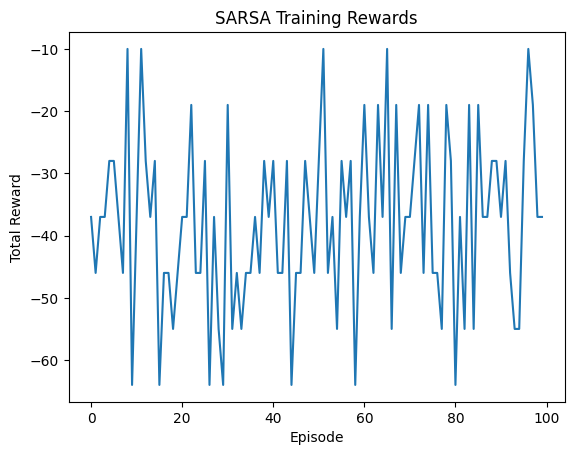

SARSA Evaluation Mean Reward: -15.49


In [14]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import random

# For DQN (Deep Q-Learning)
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Set random seeds for reproducibility
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

###############################
# Q-LEARNING IMPLEMENTATION
###############################
def train_q_learning(env, num_episodes=100, max_steps=10, alpha=0.1, gamma=0.99,
                     epsilon=1.0, min_epsilon=0.01, decay_rate=0.001):
    Q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_all_episodes = []

    for episode in range(num_episodes):
        # The change is here: handle cases where env.reset() returns int or tuple
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result

        total_reward = 0

        for step in range(max_steps):
            # Epsilon-greedy action selection
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q_table[state, :])

            # The change is here: handle cases where env.step() returns 4 or 5 values
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
                terminated = done
                truncated = False  # Assuming truncated is not relevant in this case
            else:
                next_state, reward, terminated, truncated, _ = step_result
            #done = terminated or truncated  # This line is now redundant

            # Q-learning update: using max over next state's actions
            Q_table[state, action] = (1 - alpha) * Q_table[state, action] + \
                                     alpha * (reward + gamma * np.max(Q_table[next_state, :]))

            state = next_state
            total_reward += reward
            if terminated or truncated: #Change here to check for either termination or truncation
                break

        rewards_all_episodes.append(total_reward)
        # Decay epsilon after each episode
        epsilon = min_epsilon + (1.0 - min_epsilon) * np.exp(-decay_rate * episode)

    return Q_table, rewards_all_episodes



def train_sarsa(env, num_episodes=100, max_steps=10, alpha=0.1, gamma=0.99,
                epsilon=1.0, min_epsilon=0.01, decay_rate=0.001):
    Q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_all_episodes = []

    for episode in range(num_episodes):
        # The change is here: handle cases where env.reset() returns int or tuple
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result  # Handle the usual case with a tuple

        total_reward = 0

        # Choose initial action with epsilon-greedy
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[state, :])

        for step in range(max_steps):
            # The change is here: handle cases where env.step() returns 4 or 5 values
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
                terminated = done
                truncated = False  # Assuming truncated is not relevant in this case
            else:
                next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated

            # Choose next action using epsilon-greedy
            if np.random.uniform(0, 1) < epsilon:
                next_action = env.action_space.sample()
            else:
                next_action = np.argmax(Q_table[next_state, :])

            # SARSA update rule
            Q_table[state, action] += alpha * (reward + gamma * Q_table[next_state, next_action] - Q_table[state, action])

            state = next_state
            action = next_action
            total_reward += reward
            if done:
                break

        rewards_all_episodes.append(total_reward)
        # Decay epsilon after each episode
        epsilon = min_epsilon + (1.0 - min_epsilon) * np.exp(-decay_rate * episode)

    return Q_table, rewards_all_episodes

###############################
# DQN (Deep Q-Learning) IMPLEMENTATION
###############################

# Define a simple neural network to approximate Q-values.
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

# Replay Memory to store experience tuples
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def one_hot(state, state_size):
    vec = np.zeros(state_size)
    vec[state] = 1.0
    return vec

def train_dqn(env, num_episodes=100, max_steps=10, gamma=0.99,
              epsilon=1.0, min_epsilon=0.1, decay_rate=0.001, lr=0.001,
              batch_size=64, memory_capacity=10000, target_update=10):
    state_size = env.observation_space.n
    action_size = env.action_space.n

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy_net = DQN(state_size, action_size).to(device)
    target_net = DQN(state_size, action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayMemory(memory_capacity)
    rewards_all_episodes = []
    steps_done = 0

    for episode in range(num_episodes):
        # The change is here: handle cases where env.reset() returns int or tuple
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result

        state_vec = one_hot(state, state_size)
        total_reward = 0

        for t in range(max_steps):
            # Epsilon-greedy action selection
            eps_threshold = min_epsilon + (epsilon - min_epsilon) * np.exp(-decay_rate * steps_done)
            steps_done += 1
            if random.random() < eps_threshold:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state_vec).unsqueeze(0).to(device)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax().item()

            # The change is here: handle cases where env.step() returns 4 or 5 values
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
                terminated = done
                truncated = False  # Assuming truncated is not relevant in this case
            else:
                next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated

            next_state_vec = one_hot(next_state, state_size)
            memory.push(state_vec, action, reward, next_state_vec, done)
            state_vec = next_state_vec
            total_reward += reward

            # Learn only if enough samples have been collected
            if len(memory) >= batch_size:
                batch = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*batch)

                batch_state = torch.FloatTensor(batch_state).to(device)
                batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(device)
                batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
                batch_next_state = torch.FloatTensor(batch_next_state).to(device)
                batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

                current_q = policy_net(batch_state).gather(1, batch_action)
                next_q = target_net(batch_next_state).max(1)[0].unsqueeze(1).detach()
                expected_q = batch_reward + (gamma * next_q * (1 - batch_done))

                loss = nn.MSELoss()(current_q, expected_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        rewards_all_episodes.append(total_reward)
        # Update target network periodically
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")

    return policy_net, rewards_all_episodes

###############################
# EVALUATION FUNCTIONS
###############################
def evaluate_policy(env, Q_table, num_episodes=100, max_steps=10):
    total_rewards = []
    for episode in range(num_episodes):
        # The change is here to handle cases where env.reset() returns int or tuple
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result  # Handle the usual case with a tuple

        episode_reward = 0
        for t in range(max_steps):
            action = np.argmax(Q_table[state, :])
            # The change is here: handling different return values from env.step()
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
                terminated = done
                truncated = False
            else:
                next_state, reward, terminated, truncated, _ = step_result

            episode_reward += reward
            state = next_state
            if terminated or truncated:
                break
        total_rewards.append(episode_reward)
    mean_reward = np.mean(total_rewards)
    return mean_reward

def evaluate_dqn(env, policy_net, num_episodes=100, max_steps=10):
    state_size = env.observation_space.n
    total_rewards = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for episode in range(num_episodes):
        # The change is here to handle cases where env.reset() returns int or tuple
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result  # Handle the usual case with a tuple

        state_vec = one_hot(state, state_size)
        episode_reward = 0
        for t in range(max_steps):
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state_vec).unsqueeze(0).to(device)
                q_values = policy_net(state_tensor)
                action = q_values.argmax().item()

            # The change is here: handle cases where env.step() returns 4 or 5 values
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
                terminated = done
                truncated = False  # Assuming truncated is not relevant in this case
            else:
                next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated

            episode_reward += reward
            state_vec = one_hot(next_state, state_size)
            if done:
                break
        total_rewards.append(episode_reward)
    mean_reward = np.mean(total_rewards)
    return mean_reward

###############################
# MAIN FUNCTION
###############################

def main():
    # Create the Taxi-v3 environment with RGB rendering (for consistency with Gym v0.26+)
    env = gym.make("Taxi-v3", render_mode="rgb_array")

    algorithm = input("Choose algorithm (q_learning, sarsa, dqn): ").strip().lower()

    if algorithm == "q_learning":
        print("Training Q-learning agent...")
        Q_table, rewards = train_q_learning(env)
        plt.plot(rewards)
        plt.title("Q-learning Training Rewards")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.show()
        mean_reward = evaluate_policy(env, Q_table)
        print(f"Q-learning Evaluation Mean Reward: {mean_reward:.2f}")

    elif algorithm == "sarsa":
        print("Training SARSA agent...")
        Q_table, rewards = train_sarsa(env)
        plt.plot(rewards)
        plt.title("SARSA Training Rewards")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.show()
        mean_reward = evaluate_policy(env, Q_table)
        print(f"SARSA Evaluation Mean Reward: {mean_reward:.2f}")

    elif algorithm == "dqn":
        print("Training DQN agent...")
        policy_net, rewards = train_dqn(env)
        plt.plot(rewards)
        plt.title("DQN Training Rewards")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.show()
        mean_reward = evaluate_dqn(env, policy_net)
        print(f"DQN Evaluation Mean Reward: {mean_reward:.2f}")

    else:
        print("Unknown algorithm selected.")

    env.close()

if __name__ == "__main__":
    main()


# 2.

Training Q-learning agent...


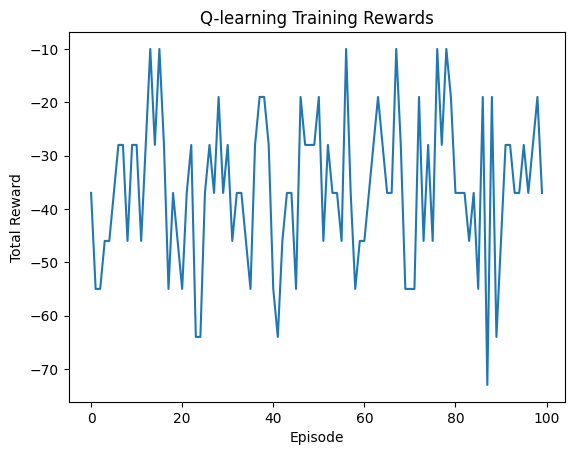

Q-learning Evaluation Mean Reward: -13.78
Training SARSA agent...


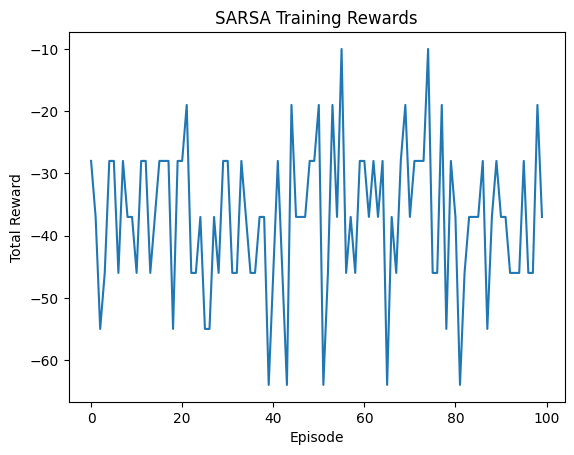

SARSA Evaluation Mean Reward: -20.26
Training DQN agent...
Episode 0, Total Reward: -28


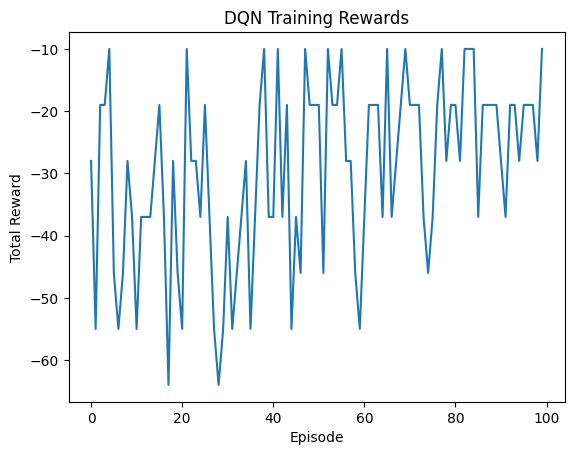

DQN Evaluation Mean Reward: -10.00


In [15]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import random

# For DQN (Deep Q-Learning)
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Set random seeds for reproducibility
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

###############################
# Q-LEARNING IMPLEMENTATION
###############################
def train_q_learning(env, num_episodes=100, max_steps=10, alpha=0.1, gamma=0.99,
                     epsilon=1.0, min_epsilon=0.01, decay_rate=0.001):
    Q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_all_episodes = []

    for episode in range(num_episodes):
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result

        total_reward = 0

        for step in range(max_steps):
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q_table[state, :])

            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
                terminated = done
                truncated = False
            else:
                next_state, reward, terminated, truncated, _ = step_result

            Q_table[state, action] = (1 - alpha) * Q_table[state, action] + \
                                     alpha * (reward + gamma * np.max(Q_table[next_state, :]))

            state = next_state
            total_reward += reward
            if terminated or truncated:
                break

        rewards_all_episodes.append(total_reward)
        epsilon = min_epsilon + (1.0 - min_epsilon) * np.exp(-decay_rate * episode)

    return Q_table, rewards_all_episodes

###############################
# SARSA IMPLEMENTATION
###############################
def train_sarsa(env, num_episodes=100, max_steps=10, alpha=0.1, gamma=0.99,
                epsilon=1.0, min_epsilon=0.01, decay_rate=0.001):
    Q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_all_episodes = []

    for episode in range(num_episodes):
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result

        total_reward = 0

        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[state, :])

        for step in range(max_steps):
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
                terminated = done
                truncated = False
            else:
                next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated

            if np.random.uniform(0, 1) < epsilon:
                next_action = env.action_space.sample()
            else:
                next_action = np.argmax(Q_table[next_state, :])

            Q_table[state, action] += alpha * (reward + gamma * Q_table[next_state, next_action] - Q_table[state, action])

            state = next_state
            action = next_action
            total_reward += reward
            if done:
                break

        rewards_all_episodes.append(total_reward)
        epsilon = min_epsilon + (1.0 - min_epsilon) * np.exp(-decay_rate * episode)

    return Q_table, rewards_all_episodes

###############################
# DQN (Deep Q-Learning) IMPLEMENTATION
###############################
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def one_hot(state, state_size):
    vec = np.zeros(state_size)
    vec[state] = 1.0
    return vec

def train_dqn(env, num_episodes=100, max_steps=10, gamma=0.99,
              epsilon=1.0, min_epsilon=0.1, decay_rate=0.001, lr=0.001,
              batch_size=64, memory_capacity=10000, target_update=10):
    state_size = env.observation_space.n
    action_size = env.action_space.n

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy_net = DQN(state_size, action_size).to(device)
    target_net = DQN(state_size, action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayMemory(memory_capacity)
    rewards_all_episodes = []
    steps_done = 0

    for episode in range(num_episodes):
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result

        state_vec = one_hot(state, state_size)
        total_reward = 0

        for t in range(max_steps):
            eps_threshold = min_epsilon + (epsilon - min_epsilon) * np.exp(-decay_rate * steps_done)
            steps_done += 1
            if random.random() < eps_threshold:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state_vec).unsqueeze(0).to(device)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax().item()

            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
                terminated = done
                truncated = False
            else:
                next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated

            next_state_vec = one_hot(next_state, state_size)
            memory.push(state_vec, action, reward, next_state_vec, done)
            state_vec = next_state_vec
            total_reward += reward

            if len(memory) >= batch_size:
                batch = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*batch)

                batch_state = torch.FloatTensor(batch_state).to(device)
                batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(device)
                batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
                batch_next_state = torch.FloatTensor(batch_next_state).to(device)
                batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

                current_q = policy_net(batch_state).gather(1, batch_action)
                next_q = target_net(batch_next_state).max(1)[0].unsqueeze(1).detach()
                expected_q = batch_reward + (gamma * next_q * (1 - batch_done))

                loss = nn.MSELoss()(current_q, expected_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        rewards_all_episodes.append(total_reward)
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")

    return policy_net, rewards_all_episodes

###############################
# EVALUATION FUNCTIONS
###############################
def evaluate_policy(env, Q_table, num_episodes=100, max_steps=10):
    total_rewards = []
    for episode in range(num_episodes):
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result

        episode_reward = 0
        for t in range(max_steps):
            action = np.argmax(Q_table[state, :])
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
                terminated = done
                truncated = False
            else:
                next_state, reward, terminated, truncated, _ = step_result

            episode_reward += reward
            state = next_state
            if terminated or truncated:
                break
        total_rewards.append(episode_reward)
    mean_reward = np.mean(total_rewards)
    return mean_reward

def evaluate_dqn(env, policy_net, num_episodes=100, max_steps=10):
    state_size = env.observation_space.n
    total_rewards = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for episode in range(num_episodes):
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result

        state_vec = one_hot(state, state_size)
        episode_reward = 0
        for t in range(max_steps):
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state_vec).unsqueeze(0).to(device)
                q_values = policy_net(state_tensor)
                action = q_values.argmax().item()

            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
                terminated = done
                truncated = False
            else:
                next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated

            episode_reward += reward
            state_vec = one_hot(next_state, state_size)
            if done:
                break
        total_rewards.append(episode_reward)
    mean_reward = np.mean(total_rewards)
    return mean_reward

###############################
# MAIN FUNCTION
###############################
def plot_rewards(rewards, title):
    plt.plot(rewards)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.show()

def main():
    env = gym.make("Taxi-v3", render_mode="rgb_array")

    print("Training Q-learning agent...")
    Q_table_q_learning, rewards_q_learning = train_q_learning(env)
    plot_rewards(rewards_q_learning, "Q-learning Training Rewards")
    mean_reward_q_learning = evaluate_policy(env, Q_table_q_learning)
    print(f"Q-learning Evaluation Mean Reward: {mean_reward_q_learning:.2f}")

    print("Training SARSA agent...")
    Q_table_sarsa, rewards_sarsa = train_sarsa(env)
    plot_rewards(rewards_sarsa, "SARSA Training Rewards")
    mean_reward_sarsa = evaluate_policy(env, Q_table_sarsa)
    print(f"SARSA Evaluation Mean Reward: {mean_reward_sarsa:.2f}")

    print("Training DQN agent...")
    policy_net_dqn, rewards_dqn = train_dqn(env)
    plot_rewards(rewards_dqn, "DQN Training Rewards")
    mean_reward_dqn = evaluate_dqn(env, policy_net_dqn)
    print(f"DQN Evaluation Mean Reward: {mean_reward_dqn:.2f}")

    env.close()

if __name__ == "__main__":
    main()

In [16]:
import matplotlib.animation as animation

def animate_policy(env, Q_table, max_steps=10):
    fig = plt.figure()
    frames = []

    reset_result = env.reset()
    if isinstance(reset_result, int):
        state = reset_result
    else:
        state, _ = reset_result

    for t in range(max_steps):
        action = np.argmax(Q_table[state, :])
        step_result = env.step(action)
        if len(step_result) == 4:
            next_state, reward, done, _ = step_result
            terminated = done
            truncated = False
        else:
            next_state, reward, terminated, truncated, _ = step_result

        img = env.render()
        frames.append([plt.imshow(img, animated=True)])

        state = next_state
        if terminated or truncated:
            break

    ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True, repeat_delay=1000)
    plt.show()

# Example usage:
# animate_policy(env, Q_table_q_learning)

# 3.

Training Q-learning agent...


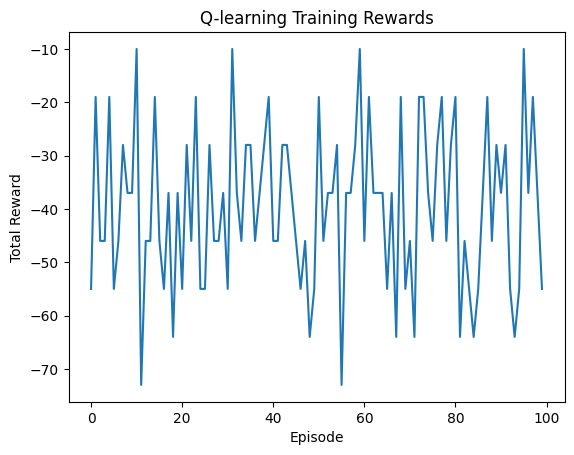

Q-learning Evaluation Mean Reward: -14.41
Training SARSA agent...


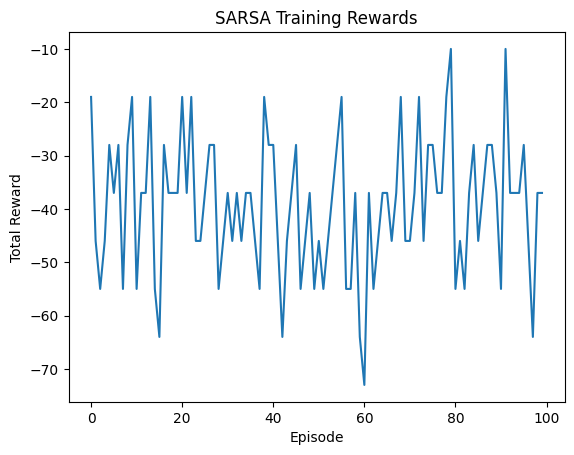

SARSA Evaluation Mean Reward: -16.48
Training DQN agent...
Episode 0, Total Reward: -37


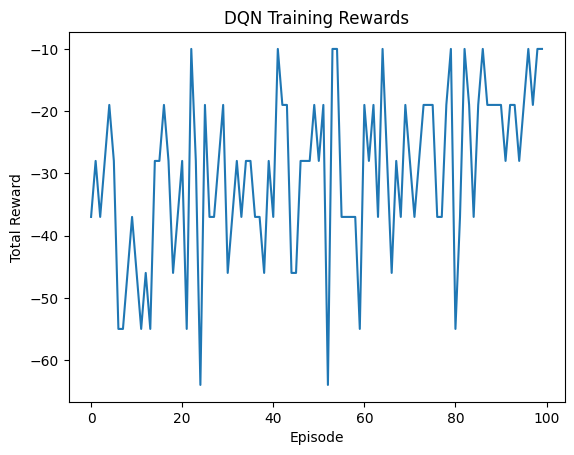

DQN Evaluation Mean Reward: -10.00
Animating Q-learning agent...


TypeError: Invalid shape (1, 350, 550, 3) for image data

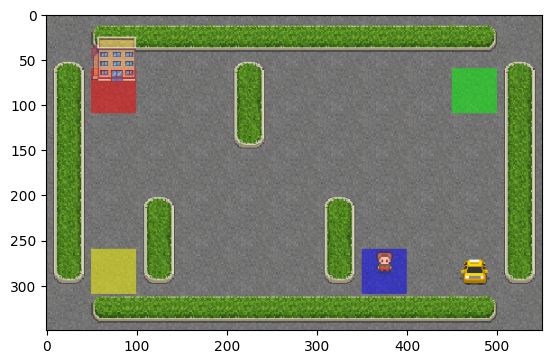

In [25]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import random
import matplotlib.animation as animation

# For DQN (Deep Q-Learning)
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Set random seeds for reproducibility
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

###############################
# Q-LEARNING IMPLEMENTATION
###############################
def train_q_learning(env, num_episodes=100, max_steps=10, alpha=0.1, gamma=0.99,
                     epsilon=1.0, min_epsilon=0.01, decay_rate=0.001):
    Q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_all_episodes = []

    for episode in range(num_episodes):
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result

        total_reward = 0

        for step in range(max_steps):
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q_table[state, :])

            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
                terminated = done
                truncated = False
            else:
                next_state, reward, terminated, truncated, _ = step_result

            Q_table[state, action] = (1 - alpha) * Q_table[state, action] + \
                                     alpha * (reward + gamma * np.max(Q_table[next_state, :]))

            state = next_state
            total_reward += reward
            if terminated or truncated:
                break

        rewards_all_episodes.append(total_reward)
        epsilon = min_epsilon + (1.0 - min_epsilon) * np.exp(-decay_rate * episode)

    return Q_table, rewards_all_episodes

###############################
# SARSA IMPLEMENTATION
###############################
def train_sarsa(env, num_episodes=100, max_steps=10, alpha=0.1, gamma=0.99,
                epsilon=1.0, min_epsilon=0.01, decay_rate=0.001):
    Q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_all_episodes = []

    for episode in range(num_episodes):
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result

        total_reward = 0

        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[state, :])

        for step in range(max_steps):
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
                terminated = done
                truncated = False
            else:
                next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated

            if np.random.uniform(0, 1) < epsilon:
                next_action = env.action_space.sample()
            else:
                next_action = np.argmax(Q_table[next_state, :])

            Q_table[state, action] += alpha * (reward + gamma * Q_table[next_state, next_action] - Q_table[state, action])

            state = next_state
            action = next_action
            total_reward += reward
            if done:
                break

        rewards_all_episodes.append(total_reward)
        epsilon = min_epsilon + (1.0 - min_epsilon) * np.exp(-decay_rate * episode)

    return Q_table, rewards_all_episodes

###############################
# DQN (Deep Q-Learning) IMPLEMENTATION
###############################
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def one_hot(state, state_size):
    vec = np.zeros(state_size)
    vec[state] = 1.0
    return vec

def train_dqn(env, num_episodes=100, max_steps=10, gamma=0.99,
              epsilon=1.0, min_epsilon=0.1, decay_rate=0.001, lr=0.001,
              batch_size=64, memory_capacity=10000, target_update=10):
    state_size = env.observation_space.n
    action_size = env.action_space.n

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy_net = DQN(state_size, action_size).to(device)
    target_net = DQN(state_size, action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayMemory(memory_capacity)
    rewards_all_episodes = []
    steps_done = 0

    for episode in range(num_episodes):
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result

        state_vec = one_hot(state, state_size)
        total_reward = 0

        for t in range(max_steps):
            eps_threshold = min_epsilon + (epsilon - min_epsilon) * np.exp(-decay_rate * steps_done)
            steps_done += 1
            if random.random() < eps_threshold:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state_vec).unsqueeze(0).to(device)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax().item()

            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
                terminated = done
                truncated = False
            else:
                next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated

            next_state_vec = one_hot(next_state, state_size)
            memory.push(state_vec, action, reward, next_state_vec, done)
            state_vec = next_state_vec
            total_reward += reward

            if len(memory) >= batch_size:
                batch = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*batch)

                batch_state = torch.FloatTensor(batch_state).to(device)
                batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(device)
                batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
                batch_next_state = torch.FloatTensor(batch_next_state).to(device)
                batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

                current_q = policy_net(batch_state).gather(1, batch_action)
                next_q = target_net(batch_next_state).max(1)[0].unsqueeze(1).detach()
                expected_q = batch_reward + (gamma * next_q * (1 - batch_done))

                loss = nn.MSELoss()(current_q, expected_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        rewards_all_episodes.append(total_reward)
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")

    return policy_net, rewards_all_episodes

###############################
# EVALUATION FUNCTIONS
###############################
def evaluate_policy(env, Q_table, num_episodes=100, max_steps=10):
    total_rewards = []
    for episode in range(num_episodes):
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result

        episode_reward = 0
        for t in range(max_steps):
            action = np.argmax(Q_table[state, :])
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
                terminated = done
                truncated = False
            else:
                next_state, reward, terminated, truncated, _ = step_result

            episode_reward += reward
            state = next_state
            if terminated or truncated:
                break
        total_rewards.append(episode_reward)
    mean_reward = np.mean(total_rewards)
    return mean_reward

def evaluate_dqn(env, policy_net, num_episodes=100, max_steps=10):
    state_size = env.observation_space.n
    total_rewards = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for episode in range(num_episodes):
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result

        state_vec = one_hot(state, state_size)
        episode_reward = 0
        for t in range(max_steps):
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state_vec).unsqueeze(0).to(device)
                q_values = policy_net(state_tensor)
                action = q_values.argmax().item()

            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
                terminated = done
                truncated = False
            else:
                next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated

            episode_reward += reward
            state_vec = one_hot(next_state, state_size)
            if done:
                break
        total_rewards.append(episode_reward)
    mean_reward = np.mean(total_rewards)
    return mean_reward

###############################
# ANIMATION FUNCTION
###############################
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def animate_policy(env, Q_table, max_steps=10):
    fig = plt.figure()
    frames = []

    reset_result = env.reset()
    if isinstance(reset_result, int):
        state = reset_result
    else:
        state, _ = reset_result

    for t in range(max_steps):
        action = np.argmax(Q_table[state, :])
        step_result = env.step(action)
        if len(step_result) == 4:
            next_state, reward, done, _ = step_result
            terminated = done
            truncated = False
        else:
            next_state, reward, terminated, truncated, _ = step_result

        img = env.render()
        img = np.array(img)  # Convert to numpy array
        # Check if img has an extra dimension and select the first frame if necessary
        if img.ndim == 4 and img.shape[0] == 2:  # Check if img has shape (2, height, width, 3)
            img = img[0]  # Select the first frame

        frames.append([plt.imshow(img, animated=True)])

        state = next_state
        if terminated or truncated:
            break

    ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True, repeat_delay=1000)
    plt.show()

# Example usage:
# animate_policy(env, Q_table_q_learning)

###############################
# MAIN FUNCTION
###############################
def plot_rewards(rewards, title):
    plt.plot(rewards)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.show()

def main():
    env = gym.make("Taxi-v3", render_mode="rgb_array")

    print("Training Q-learning agent...")
    Q_table_q_learning, rewards_q_learning = train_q_learning(env)
    plot_rewards(rewards_q_learning, "Q-learning Training Rewards")
    mean_reward_q_learning = evaluate_policy(env, Q_table_q_learning)
    print(f"Q-learning Evaluation Mean Reward: {mean_reward_q_learning:.2f}")

    print("Training SARSA agent...")
    Q_table_sarsa, rewards_sarsa = train_sarsa(env)
    plot_rewards(rewards_sarsa, "SARSA Training Rewards")
    mean_reward_sarsa = evaluate_policy(env, Q_table_sarsa)
    print(f"SARSA Evaluation Mean Reward: {mean_reward_sarsa:.2f}")

    print("Training DQN agent...")
    policy_net_dqn, rewards_dqn = train_dqn(env)
    plot_rewards(rewards_dqn, "DQN Training Rewards")
    mean_reward_dqn = evaluate_dqn(env, policy_net_dqn)
    print(f"DQN Evaluation Mean Reward: {mean_reward_dqn:.2f}")

    print("Animating Q-learning agent...")
    animate_policy(env, Q_table_q_learning)

    env.close()

if __name__ == "__main__":
    main()

In [28]:
def animate_dqn_policy(env, policy_net, max_steps=10):
    fig = plt.figure()
    frames = []
    state_size = env.observation_space.n
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    reset_result = env.reset()
    if isinstance(reset_result, int):
        state = reset_result
    else:
        state, _ = reset_result

    state_vec = one_hot(state, state_size)

    for t in range(max_steps):
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state_vec).unsqueeze(0).to(device)
            q_values = policy_net(state_tensor)
            action = q_values.argmax().item()

        step_result = env.step(action)
        if len(step_result) == 4:
            next_state, reward, done, _ = step_result
            terminated = done
            truncated = False
        else:
            next_state, reward, terminated, truncated, _ = step_result

        img = env.render()
        img = np.array(img)  # Convert to numpy array
        frames.append([plt.imshow(img, animated=True)])

        state_vec = one_hot(next_state, state_size)
        state = next_state
        if terminated or truncated:
            break

    ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True, repeat_delay=1000)
    plt.show()



In [29]:
# Example usage:
env = gym.make("Taxi-v3", render_mode="rgb_array")

animate_dqn_policy(env, policy_net_dqn)

NameError: name 'policy_net_dqn' is not defined